# Creating PSSM from peptide sequences


In [2]:
### ABOUT ###
# This script creates a PSSM from out peptide sequences.

In [3]:
### Importing libraries ###
import numpy as np
import random
import copy
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# defining data directory

# f is used for training
# c is used for testing

data_dir = "../../data/"
allele = "A0101"
training_file = f'{data_dir}{allele}/f000" #just for one fold.
testing_file = data_dir + allele + "f000" #just for one fold.
test_data = f'{DATAPATH}/{ALLELE}/test_BA'
training = np.loadtxt(training_file, dtype=str)
testing = np.loadtxt(testing_file, dtype=str)


FileNotFoundError: ../../data/A0101f000 not found.

## Define options for run

In [ ]:
sequence_weighting = True
# sequence_weighting = False
# define weight on pseudo count
beta = 50
# beta = 0


## Data Imports

### Load Alphabet

In [ ]:
alphabet_file = data_dir + "Matrices/alphabet"

alphabet = np.loadtxt(alphabet_file, dtype=str)

print (alphabet)
print (len(alphabet))

['A' 'R' 'N' 'D' 'C' 'Q' 'E' 'G' 'H' 'I' 'L' 'K' 'M' 'F' 'P' 'S' 'T' 'W'
 'Y' 'V']
20


### Load Background Frequencies

In [ ]:
bg_file = data_dir + "Matrices/bg.freq.fmt"
_bg = np.loadtxt(bg_file, dtype=float)

bg = {} #creates a dictionary for the background frequencies
for i in range(0, len(alphabet)):
    bg[alphabet[i]] = _bg[i]

bg

{'A': 0.074,
 'R': 0.052,
 'N': 0.045,
 'D': 0.054,
 'C': 0.025,
 'Q': 0.034,
 'E': 0.054,
 'G': 0.074,
 'H': 0.026,
 'I': 0.068,
 'L': 0.099,
 'K': 0.058,
 'M': 0.025,
 'F': 0.047,
 'P': 0.039,
 'S': 0.057,
 'T': 0.051,
 'W': 0.013,
 'Y': 0.032,
 'V': 0.073}

### Load Blosum62 Matrix


In [ ]:
blosum62_file = data_dir + "Matrices/blosum62.freq_rownorm"
_blosum62 = np.loadtxt(blosum62_file, dtype=float).T

blosum62 = {} #creates a dictionary for the blosum62 matrix
for i, letter_1 in enumerate(alphabet):
    
    blosum62[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):
        
        blosum62[letter_1][letter_2] = _blosum62[i, j]

blosum62

{'A': {'A': 0.2901,
  'R': 0.0446,
  'N': 0.0427,
  'D': 0.041,
  'C': 0.065,
  'Q': 0.0559,
  'E': 0.0552,
  'G': 0.0783,
  'H': 0.042,
  'I': 0.0471,
  'L': 0.0445,
  'K': 0.057,
  'M': 0.0522,
  'F': 0.0338,
  'P': 0.0568,
  'S': 0.1099,
  'T': 0.073,
  'W': 0.0303,
  'Y': 0.0405,
  'V': 0.07},
 'R': {'A': 0.031,
  'R': 0.345,
  'N': 0.0449,
  'D': 0.0299,
  'C': 0.0163,
  'Q': 0.0735,
  'E': 0.0497,
  'G': 0.0229,
  'H': 0.0458,
  'I': 0.0177,
  'L': 0.0243,
  'K': 0.1071,
  'M': 0.0321,
  'F': 0.019,
  'P': 0.0258,
  'S': 0.0401,
  'T': 0.0355,
  'W': 0.0227,
  'Y': 0.028,
  'V': 0.0219},
 'N': {'A': 0.0256,
  'R': 0.0388,
  'N': 0.3169,
  'D': 0.069,
  'C': 0.0163,
  'Q': 0.0441,
  'E': 0.0405,
  'G': 0.0391,
  'H': 0.0534,
  'I': 0.0147,
  'L': 0.0142,
  'K': 0.0415,
  'M': 0.0201,
  'F': 0.0169,
  'P': 0.0233,
  'S': 0.0541,
  'T': 0.0434,
  'W': 0.0152,
  'Y': 0.0218,
  'V': 0.0165},
 'D': {'A': 0.0297,
  'R': 0.031,
  'N': 0.0831,
  'D': 0.3974,
  'C': 0.0163,
  'Q': 0.0471,


### Load Peptides

In [ ]:
# peptides_file = data_dir + "PSSM/A0201.single_lig"
peptides_file = data_dir + "PSSM/A0201.small_lig"
#peptides_file = data_dir + "PSSM/A0201.large_lig"

peptides = np.loadtxt(peptides_file, dtype=str).tolist() # load peptides from file

#saving the length of the peptides.
if len(peptides[0]) == 1:
    peptide_length = len(peptides)
    peptides = [peptides]
else:
    peptide_length = len(peptides[0])

# check if all peptides are of the same length
for i in range(0, len(peptides)):
    if len(peptides[i]) != peptide_length:
        print("Error, peptides differ in length!")
        
# print(peptides)

## Initialize Matrix

In [ ]:
#Function for initializing matrix.
def initialize_matrix(peptide_length, alphabet):

    init_matrix = [0]*peptide_length # makes a list of zeros with length equal to peptide_length

    for i in range(0, peptide_length):

        row = {}

        for letter in alphabet: 
            row[letter] = 0.0 #adds values of 0 for each possible substitution.

        #fancy way:  row = dict( zip( alphabet, [0.0]*len(alphabet) ) )

        init_matrix[i] = row
        
    return init_matrix

## Amino Acid Count Matrix (c)

In [ ]:
c_matrix = initialize_matrix(peptide_length, alphabet)

for position in range(0, peptide_length):
        
    for peptide in peptides:
        
        c_matrix[position][peptide[position]] += 1

        
pprint(c_matrix[0]) # looking at the counts for position 0.


{'A': 6.0,
 'C': 0.0,
 'D': 0.0,
 'E': 0.0,
 'F': 0.0,
 'G': 2.0,
 'H': 0.0,
 'I': 0.0,
 'K': 1.0,
 'L': 0.0,
 'M': 0.0,
 'N': 0.0,
 'P': 0.0,
 'Q': 0.0,
 'R': 0.0,
 'S': 0.0,
 'T': 1.0,
 'V': 0.0,
 'W': 0.0,
 'Y': 0.0}


## Sequence Weighting

In [ ]:
# w = 1 / r * s
# where 
# r = number of different amino acids in column
# s = number of occurrence of amino acid in column

weights = {}

for peptide in peptides:

    # apply sequence weighting
    if sequence_weighting:
    
        w = 0.0
        neff = 0.0
        
        for position in range(0, peptide_length):

            r = 0

            for letter in alphabet:        

                if c_matrix[position][letter] != 0: #if the count of the amino acid is not zero
                    
                    r += 1 #counting how many different amino acids there are in the column

            s = c_matrix[position][peptide[position]] #number of occurrences of the amino acid in the column

            w += 1.0/(r * s) #calculating the weight for the peptide

            neff += r #adding the number of different amino acids in the column to neff
                
        neff = neff / peptide_length # average number of different amino acids per position
  
    # do not apply sequence weighting
    else:
        
        w = 1  
        
        neff = len(peptides)  
      

    weights[peptide] = w

pprint( "W:")
pprint( weights )
pprint( "Nseq:")
pprint( neff )

'W:'
{'ALAKAAAAM': 0.414047619047619,
 'ALAKAAAAN': 0.49738095238095237,
 'ALAKAAAAR': 0.49738095238095237,
 'ALAKAAAAT': 0.414047619047619,
 'ALAKAAAAV': 0.3862698412698412,
 'AVVPFIVSV': 1.513888888888889,
 'GILGFVFTM': 1.4583333333333333,
 'GMNERPILT': 1.3583333333333334,
 'KLNEPVLLL': 1.185714285714286,
 'TLNAWVKVV': 1.2746031746031745}
'Nseq:'
4.777777777777778


## Observed Frequencies Matrix (f)

In [ ]:
f_matrix = initialize_matrix(peptide_length, alphabet) #initialize zero matrix for frequencies

for position in range(0, peptide_length):
  
    n = 0;
  
    for peptide in peptides:
    
        f_matrix[position][peptide[position]] += weights[peptide] 
    
        n += weights[peptide] #saving the sum of weights (corresponds to n) to normalize the frequencies later
        
    for letter in alphabet: 
        
        f_matrix[position][letter] = f_matrix[position][letter]/n
      
pprint( f_matrix[0] )

{'A': 0.41366843033509704,
 'C': 0.0,
 'D': 0.0,
 'E': 0.0,
 'F': 0.0,
 'G': 0.31296296296296294,
 'H': 0.0,
 'I': 0.0,
 'K': 0.13174603174603178,
 'L': 0.0,
 'M': 0.0,
 'N': 0.0,
 'P': 0.0,
 'Q': 0.0,
 'R': 0.0,
 'S': 0.0,
 'T': 0.14162257495590827,
 'V': 0.0,
 'W': 0.0,
 'Y': 0.0}


## Pseudo Frequencies Matrix (g)

Remember g(b) = sum f(a)* q(b|a), and blosum[a,b] = q(a|b)

In [ ]:
g_matrix = initialize_matrix(peptide_length, alphabet)

for position in range(0, peptide_length):

    for letter_1 in alphabet:
        for letter_2 in alphabet:

          g_matrix[position][letter_1] += f_matrix[position][letter_2] * blosum62[letter_1][letter_2]

pprint(g_matrix[0]) #just printing the first row of the g_matrix

{'A': 0.16235818342151676,
 'C': 0.01596913580246914,
 'D': 0.03361111111111111,
 'E': 0.03967297178130512,
 'F': 0.019403756613756616,
 'G': 0.20387049382716046,
 'H': 0.015028827160493828,
 'I': 0.03497014991181658,
 'K': 0.07202333333333333,
 'L': 0.04833981481481482,
 'M': 0.015013077601410936,
 'N': 0.034440643738977074,
 'P': 0.025745925925925926,
 'Q': 0.02746210758377425,
 'R': 0.03912817460317461,
 'S': 0.07139364197530865,
 'T': 0.07007733686067019,
 'V': 0.050441860670194,
 'W': 0.0054444620811287476,
 'Y': 0.015419285714285715}


## Combined Frequencies Matrix (p)

In [ ]:
p_matrix = initialize_matrix(peptide_length, alphabet)

alpha = neff - 1 # alpha is the number of different amino acids minus one

for position in range(0, peptide_length):

    for a in alphabet:
        p_matrix[position][a] = (alpha * f_matrix[position][a] + beta * g_matrix[position][a]) / (alpha + beta)

pprint(p_matrix[0]) #just printing the first position of the p_matrix

{'A': 0.1800122090311484,
 'C': 0.014847337006427918,
 'D': 0.03125,
 'E': 0.0368860274826184,
 'F': 0.01804068280204644,
 'G': 0.2115340143862871,
 'H': 0.013973083103764921,
 'I': 0.03251356913288732,
 'K': 0.0762187295028204,
 'L': 0.04494404269972452,
 'M': 0.013958439918667192,
 'N': 0.03202125967466877,
 'P': 0.02393732782369146,
 'Q': 0.02553295126590581,
 'R': 0.03637950118063755,
 'S': 0.06637838613406796,
 'T': 0.0751032420161208,
 'V': 0.04689842417683327,
 'W': 0.005061999868818051,
 'Y': 0.014336112750885479}


## Log Odds Weight Matrix (w)

In [ ]:
w_matrix = initialize_matrix(peptide_length, alphabet)

for position in range(0, peptide_length):
    
    for letter in alphabet:
        if p_matrix[position][letter] > 0: #check if the probability is greater than zero because log(0) is not handled.
            w_matrix[position][letter] = 2 * math.log(p_matrix[position][letter]/bg[letter])/math.log(2)
        else:
            w_matrix[position][letter] = -999.9

pprint(w_matrix[0])

{'A': 2.5649951648610188,
 'C': -1.5034478000643317,
 'D': -1.578206435002763,
 'E': -1.0997699678355286,
 'F': -2.7628136283579807,
 'G': 3.0305849791504804,
 'H': -1.7917224852185845,
 'I': -2.1289856235063973,
 'K': 0.7881853193816127,
 'L': -2.278597249923568,
 'M': -1.6815807776501963,
 'N': -0.9817898774541316,
 'P': -1.4084240278213043,
 'Q': -0.8263488856568618,
 'R': -1.0307717234288374,
 'S': 0.4395032682836657,
 'T': 1.1167558789573315,
 'V': -1.2767140322038806,
 'W': -2.72146449616,
 'Y': -2.3168360320583425}


### Write Matrix to PSI-BLAST format

In [ ]:
def to_psi_blast(matrix):

    header = ["", "A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    print ('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*header)) 

    letter_order = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    for i, row in enumerate(matrix):

        scores = []

        scores.append(str(i+1) + " A")

        for letter in letter_order:

            score = row[letter]

            scores.append(round(score, 4))

        print('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*scores)) 

### convert w_matrix to PSI-BLAST format and print to file

In [ ]:
def to_psi_blast_file(matrix, file_name):
    
    with open(file_name, 'w') as file:

        header = ["", "A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

        file.write ('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}\n'.format(*header)) 

        letter_order = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

        for i, row in enumerate(matrix):

            scores = []

            scores.append(str(i+1) + " A")

            for letter in letter_order:

                score = row[letter]

                scores.append(round(score, 4))

            file.write('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}\n'.format(*scores)) 

### convert  w_matrix to PSI-BLAST format

In [ ]:
to_psi_blast(w_matrix)

            A        R        N        D        C        Q        E        G        H        I        L        K        M        F        P        S        T        W        Y        V
 1 A    2.565  -1.0308  -0.9818  -1.5782  -1.5034  -0.8263  -1.0998   3.0306  -1.7917   -2.129  -2.2786   0.7882  -1.6816  -2.7628  -1.4084   0.4395   1.1168  -2.7215  -2.3168  -1.2767
 2 A  -1.3199  -2.4406  -3.2746  -3.5823  -1.3761  -2.1139  -2.8662  -3.6091  -2.8332   2.2383   3.1097   -2.439   2.8681  -0.1004  -2.9759  -2.2985  -1.0474  -2.0918    -1.29   1.8761
 3 A    1.345  -1.4123   3.7556  -0.5496  -1.6889  -0.9861   -1.217  -1.0933  -0.9652  -0.2729    0.415  -1.1222   -0.527  -1.7245   -2.005  -0.0665  -0.4501  -2.7934  -1.8646   0.7514
 4 A   0.7613  -0.1673  -0.8931  -0.3998  -2.6469   0.3674    2.508   1.4722  -1.1415  -2.9247  -2.8183    2.048  -2.0562  -3.2567   2.9612  -0.2371  -1.0504  -3.0207  -2.3323  -2.2665
 5 A   1.1708   1.1726  -2.1539  -2.5758  -2.2303  -1.4703  -1.7115  -1.869

### convert w_matrix to PSI-BLAST format and print to file

In [ ]:
# Write out PSSM in Psi-Blast format to file
file_name = "w_matrix_test"
to_psi_blast_file(w_matrix, file_name=file_name)

## Evaluation

In [ ]:
# #evaluation_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_2/A0201.eval"
# evaluation_file = data_dir + "PSSM/A0201.eval"
# #evaluation_file = evaluation_upload.values()

# evaluation = np.loadtxt(evaluation_file, dtype=str).reshape(-1,2)
# evaluation_peptides = evaluation[:, 0]
# evaluation_targets = evaluation[:, 1].astype(float)

# evaluation_peptides, evaluation_targets

(array(['ILYQVPFSV', 'VVMGTLVAL', 'ILDEAYVMA', ..., 'FARGVVHVI',
        'LQRELTRLQ', 'AVAEEMTKS'], dtype='<U9'),
 array([0.8532, 0.5891, 0.4941, ..., 0.    , 0.    , 0.    ]))

In [ ]:
# def score_peptide(peptide, matrix):
#     acum = 0
#     for i in range(0, len(peptide)):
#         acum += w_matrix[i][peptide[i]]
#     return acum

In [ ]:
# evaluation_predictions = []
# for evaluation_peptide in evaluation_peptides:
#     evaluation_predictions.append(score_peptide(evaluation_peptide, w_matrix))

PCC:  0.47668860716507033


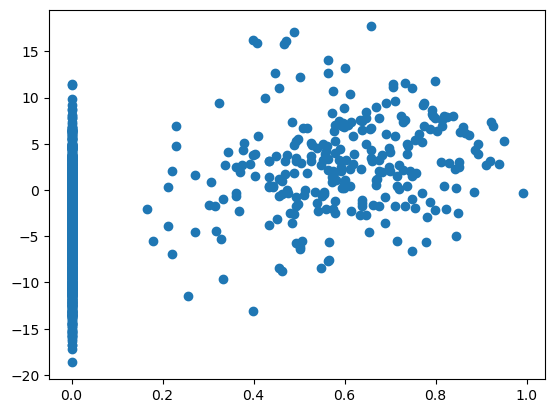

In [ ]:
# from scipy.stats import pearsonr
# import matplotlib.pyplot as plt

# pcc = pearsonr(evaluation_targets, evaluation_predictions)
# print("PCC: ", pcc[0])

# plt.scatter(evaluation_targets, evaluation_predictions);